In [1]:
# 

In [2]:
#models
import numpy as np

from keras.layers import Embedding, Reshape,Concatenate, dot, Dropout, Dense,Input,Flatten,merge,concatenate
from keras import Model
from keras.models import Sequential
import tensorflow as tf
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot



def Collaborative_FilteringModel(n_users,n_items ,emb_dim):
        user_input = Input(shape=[1])
        item_input = Input(shape=[1])
        user_embedding = Embedding(output_dim=emb_dim, input_dim=n_users + 1,
                               input_length=1)(user_input)
        item_embedding = Embedding(output_dim=emb_dim, input_dim=n_items + 1,
                               input_length=1)(item_input)
        user_vecs = Flatten()(user_embedding)
        item_vecs = Flatten()(item_embedding)
        output = dot([user_vecs, item_vecs], axes=-1)
        model = Model(inputs=[user_input, item_input], outputs=output)
        return model

def Deep_networkModel(n_users,n_movies ,emb_dim):
    n_latent_factors_user = emb_dim
    n_latent_factors_movie = emb_dim

    movie_input = Input(shape=[1],name='Item')
    movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Embedding_for_movies')(movie_input)
    movie_vec = Flatten(name='Flatten_Movies')(movie_embedding)
    movie_vec = Dropout(0.2)(movie_vec)


    user_input = Input(shape=[1],name='User')
    user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors_user,name='Embedding_for_users')(user_input))
    user_vec = Dropout(0.2)(user_vec)
    concat =concatenate([movie_vec,user_vec],axis=-1, name='concat_')
#     import random
#     x = random.random()
#     x=x/3#----just to ensure dropout random is not too large
    concat = Dropout(0.2)(concat)
    dense = Dense(30,name='hiddenlayer1',activation='tanh')(concat)
    dropout_1 = Dropout(0.2,name='Dropout')(dense)
    dense_2 = Dense(20,name='hiddenlayer2',activation='tanh')(concat)
    dropout_2 = Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = Dense(10,name='hidden3',activation='tanh')(dense_2)
    dropout_3 = Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = Dense(5,name='hidden4', activation='tanh')(dense_3)


    result = Dense(1, activation='relu',name='result_node_with_relu_activation')(dense_4)

    model = Model([user_input, movie_input], result)

    return model





#trainig.................................................................................................

import math
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# from CFModel import CFModel

RATINGS_CSV_FILE = 'ml1m_ratings.csv'
MODEL_WEIGHTS_FILE = 'ml1m_weights_exp7.h5'
K_FACTORS = 30
RNG_SEED = 14465577


ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep='\t', 
                      encoding='latin-1', 
                      usecols=['userid', 'movieid', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print (len(ratings), ':number of ratings')


shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)
Users = shuffled_ratings['user_emb_id'].values
print ('Users:', Users, ', shape =', Users.shape)
Movies = shuffled_ratings['movie_emb_id'].values
print ('Movies:', Movies, ', shape =', Movies.shape)
Ratings = shuffled_ratings['rating'].values
print ('Ratings:', Ratings, ', shape =', Ratings.shape)

model =Deep_networkModel(max_userid, max_movieid, K_FACTORS)
model.compile(loss='mse', optimizer='adamax')
batch_size=len(Ratings)
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
history = model.fit([Users, Movies],Ratings, nb_epoch=30,  verbose=2, callbacks=callbacks,validation_split=.1)


loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})


min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))


Using TensorFlow backend.


1000209 :number of ratings
Users: [4447 5393 1919 ... 3561 2877 4012] , shape = (1000209,)
Movies: [1205 2202 1906 ... 3447  234   33] , shape = (1000209,)
Ratings: [5 3 3 ... 3 4 4] , shape = (1000209,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


D:\anaconda\lib\site-packages\ipykernel_launcher.py:101: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900188 samples, validate on 100021 samples
Epoch 1/30
 - 96s - loss: 0.9178 - val_loss: 0.8342
Epoch 2/30
 - 68s - loss: 0.8357 - val_loss: 0.8304
Epoch 3/30
 - 68s - loss: 0.8197 - val_loss: 0.8089
Epoch 4/30
 - 68s - loss: 0.8118 - val_loss: 0.8143
Epoch 5/30
 - 65s - loss: 0.8060 - val_loss: 0.8010
Epoch 6/30
 - 66s - loss: 0.8018 - val_loss: 0.7981
Epoch 7/30
 - 65s - loss: 0.7982 - val_loss: 0.7965
Epoch 8/30
 - 65s - loss: 0.7949 - val_loss: 0.7911
Epoch 9/30
 - 66s - loss: 0.7907 - val_loss: 0.7893
Epoch 10/30
 - 66s - loss: 0.7870 - val_loss: 0.7838
Epoch 11/30
 - 68s - loss: 0.7832 - val_loss: 0.7817
Epoch 12/30
 - 67s - loss: 0.7797 - val_loss: 0.7778
Epoch 13/30
 - 68s - loss: 0.7755 - val_loss: 0.7753
Epoch 14/30
 - 67s - loss: 0.7729 - val_loss: 0.7757
Epoch 15/30
 - 72s - loss: 0.7699 - val_loss: 0.7721
Epoch 16/30
 - 73s - loss: 0.7672 - val_loss: 0.7773
Epoch 17/30
 - 67s - loss: 0.7652 - val_loss: 0.7709
Epoch 18/30
 - 56s - loss: 0.7633 - val_loss: 0.7687
Epo

D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


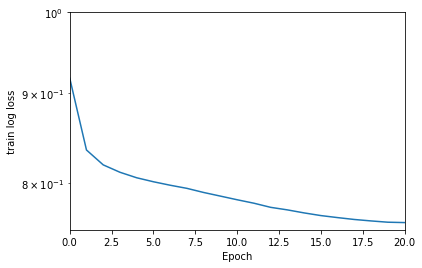

D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


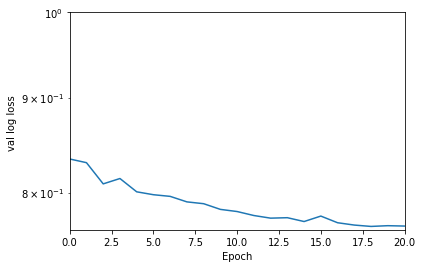

In [3]:
#plots..................................................................
pd.Series(history.history['loss']).plot(logy=True).set_ylim([0.0,1.0])
plt.xlabel("Epoch")
plt.ylabel(" train log loss ")
plt.show()
pd.Series(history.history['val_loss']).plot(logy=True).set_ylim([0.0,1.0])
plt.xlabel("Epoch")
plt.ylabel("val log loss ")
plt.show()


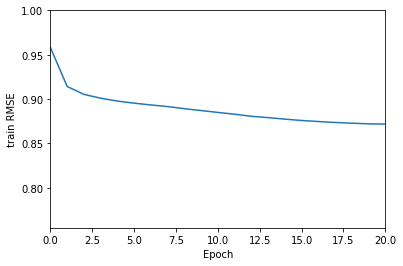

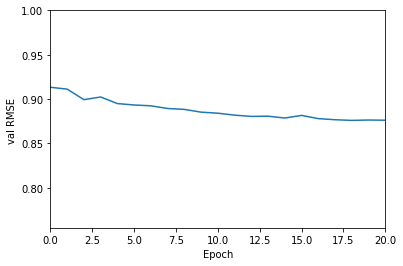

In [4]:
#plots..................................................................
pd.Series(loss['training']).plot(logy=False).set_ylim([0.755,1.0])
plt.xlabel("Epoch")
plt.ylabel(" train RMSE ")
plt.show()
pd.Series(loss['validation']).plot(logy=False).set_ylim([0.755,1.0])
plt.xlabel("Epoch")
plt.ylabel("val RMSE ")
plt.show()



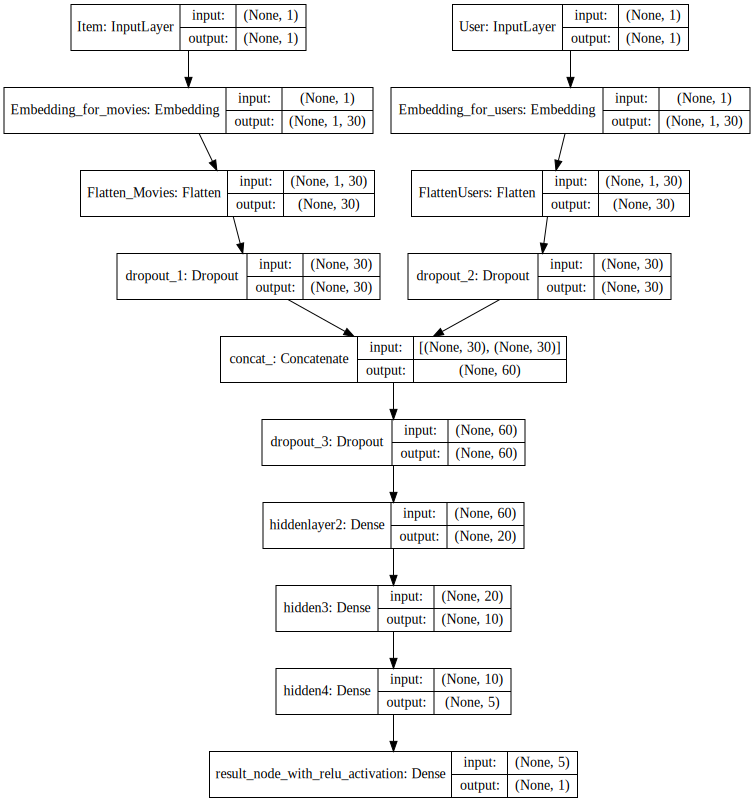

In [5]:
#architecture..................................................................
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [8]:
import pandas as pd
RATINGS_CSV_FILE = 'ml1m_ratings.csv'
USERS_CSV_FILE = 'ml1m_users.csv'
MOVIES_CSV_FILE = 'ml1m_movies.csv'
MODEL_WEIGHTS_FILE = 'ml1m_weights_exp7.h5'
K_FACTORS = 30
TEST_USER = 234#<-test user.....
top_k_ratings=10

ratings = pd.read_csv(RATINGS_CSV_FILE, sep='\t', encoding='latin-1', usecols=['userid', 'movieid', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print (len(ratings), 'ratings loaded.')

users = pd.read_csv(USERS_CSV_FILE, sep='\t', encoding='latin-1', usecols=['userid', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
print( len(users), 'descriptions of', max_userid, 'users loaded.')


movies = pd.read_csv(MOVIES_CSV_FILE, sep='\t', encoding='latin-1', usecols=['movieid', 'title', 'genre'])
print (len(movies), 'descriptions of', max_movieid, 'movies loaded.')

trained_model = Deep_networkModel(max_userid, max_movieid, K_FACTORS)

trained_model.load_weights(MODEL_WEIGHTS_FILE)
trained_model.summary()

users[users['userid'] == TEST_USER]
def predict_rating(userid, movieid):

      return trained_model.predict([np.array([userid]), np.array([movieid])])[0][0]

user_ratings = ratings[ratings['userid'] == TEST_USER][['userid', 'movieid', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movieid']), axis=1)

#Top K ratings for user..................................................................
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(top_k_ratings)

1000209 ratings loaded.
6040 descriptions of 6040 users loaded.
3883 descriptions of 3952 movies loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Embedding_for_movies (Embedding (None, 1, 30)        118590      Item[0][0]                       
__________________________________________________________________________________________________
Embedding_for_users (Embedding) (None, 1, 30)        181230      User[0][0]                       
____

,userid,movieid,rating,prediction,title,genre
0,234,1252,5,4.263545,Chinatown (1974),Film-Noir|Mystery|Thriller
1,234,805,5,3.563827,"Time to Kill, A (1996)",Drama
2,234,1090,5,2.445648,Platoon (1986),Drama|War
3,234,1198,5,4.542760,Raiders of the Lost Ark (1981),Action|Adventure
4,234,2971,5,4.405743,All That Jazz (1979),Musical
5,234,2022,5,3.177807,"Last Temptation of Christ, The (1988)",Drama
6,234,1293,5,4.395177,Gandhi (1982),Drama
7,234,2020,5,3.381841,Dangerous Liaisons (1988),Drama|Romance
8,234,3053,5,1.479713,"Messenger: The Story of Joan of Arc, The (1999)",Drama|War
9,234,1213,5,4.353209,GoodFellas (1990),Crime|Drama


In [7]:
user_ratings.sort_values(by='prediction', 
                         ascending=False).merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(top_k_ratings).to_csv("user_ratings_prediction_top_10.csv", 
              sep='\t', 
              header=True)